## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
!mprof run profiling_nerdprong.py

/bin/bash: mprof: command not found


In [2]:
import sys
sys.executable

'/wclustre/nova/users/rafaelma/m-rcnn/myenvname/bin/python'

In [3]:
!which python

/wclustre/nova/users/rafaelma2/venv385/bin/python


In [4]:
import subprocess

result = subprocess.run(['which', 'python'], stdout=subprocess.PIPE, universal_newlines=True)

# Imprimir la salida del comando
print("Salida del comando:")
print(result.stdout)

Salida del comando:
/wclustre/nova/users/rafaelma2/venv385/bin/python



In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/wclustre/

## Configurations

In [6]:
import nova_basic

class inferNovaConfig(nova_basic.novaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = inferNovaConfig()

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
dataset = nova_basic.novaDataset()
dataset_path='/wclustre/nova/users/rafaelma/dataset/'
files=os.listdir(dataset_path)
files = [dataset_path+f for f in files]
files=files[0:10]
dataset.load_nova(files)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Loaded 1202 images.
Images: 1202
Classes: ['BG', 'Electron', 'Muon', 'Proton', 'Photon', 'Pion', 'Other']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)
model.load_weights('mask_rcnn_nova_0249.h5', by_name=True)

## Run Detection

image ID: NOvA.985 (985) 
Processing 1 images
image                    shape: (256, 256, 2)         min:    0.00000  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 2)      min:    0.00000  max:  255.00000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


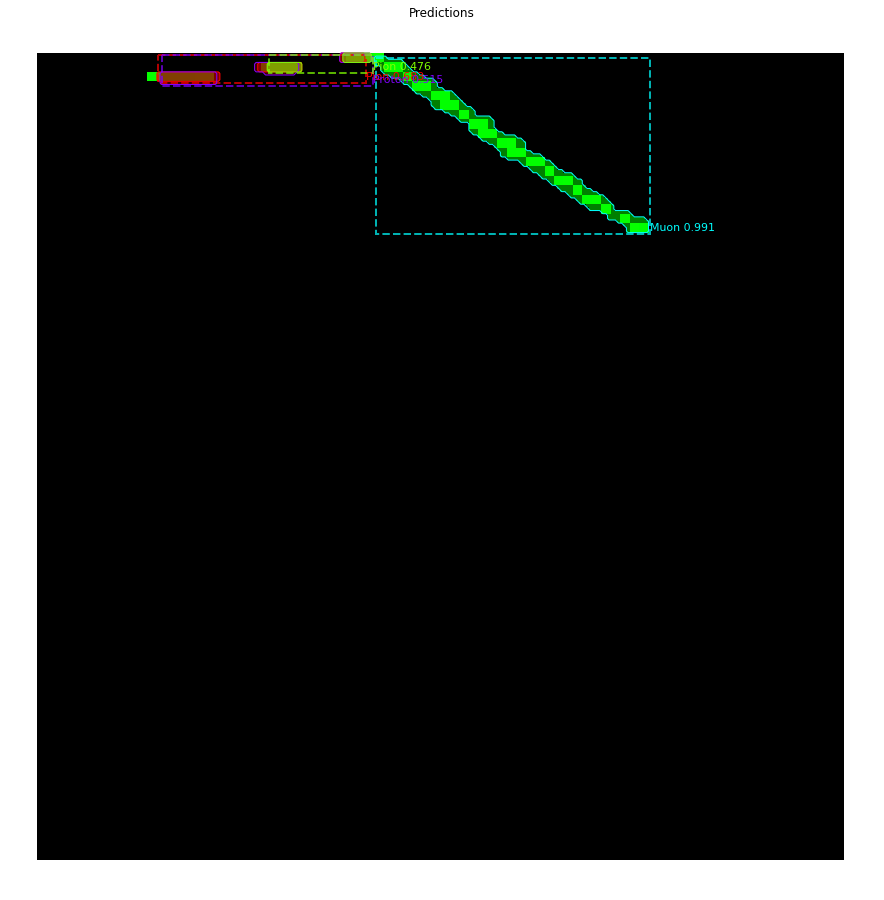

In [11]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax,title="Predictions")


In [12]:
def mask_iou_calc(masks1, masks2):
    """
    Return intersection-over-union (Jaccard index) of masks.
    Both sets of masks are expected to have the same shape.
    Arguments:
        masks1 (Array[N, H, W])
        masks2 (Array[M, H, W])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in masks1 and masks2
    """
    area1 = np.sum(masks1, axis=(1, 2))  # [N]
    area2 = np.sum(masks2, axis=(1, 2))  # [M]

    # Compute intersection between all masks combinations
    intersection = np.einsum('nij,mij->nm', masks1, masks2)  # [N, M]

    union = area1[:, np.newaxis] + area2 - intersection
    iou = intersection / union

    return iou
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/wclustre/nova/users/rafaelma/m-rcnn/myenvname/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


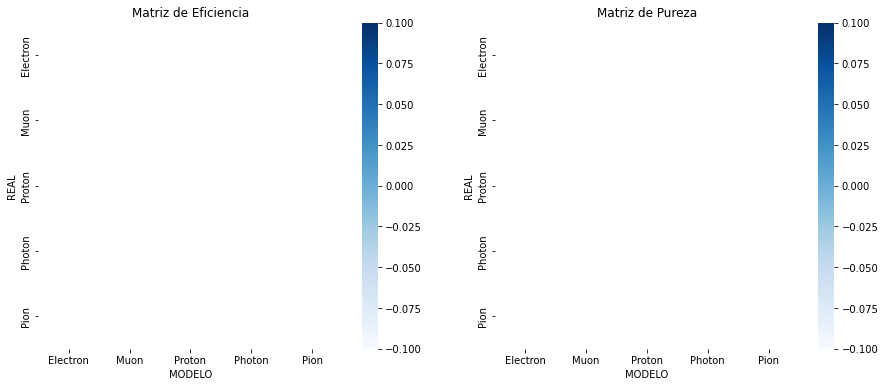

In [13]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sb
class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.1):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, outputs, real,batch_size):
        
        for i in range(batch_size):
            try:
                pred_scores = torch.tensor([d['score'] for d in outputs[i]['segments_info']]).numpy()
                pred_labels = torch.tensor([d['label_id'] for d in outputs[i]['segments_info']]).numpy()


                pred_masks = torch.stack([torch.tensor((outputs[i]['segmentation'].numpy() == x) * 1, dtype=torch.uint8) for x in range(int(torch.max(outputs[i]['segmentation'])) + 1)]).numpy()

                target_labels = torch.tensor(real['class_labels'][i].tolist()).numpy()
                target_masks = torch.tensor(real['mask_labels'][i], dtype=torch.uint8).numpy()
            
            except:
                continue

            all_ious = compute_overlaps_masks(target_masks, pred_masks)
            want_idx = np.where(all_ious > self.IOU_THRESHOLD)

            all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                           for i in range(want_idx[0].shape[0])]

            all_matches = np.array(all_matches)
            if all_matches.shape[0] > 0:  # if there is match
                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

                all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

                all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

            for i, label in enumerate(target_masks):
                gt_class = target_labels[i]
                if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                    detection_class = pred_labels[int(all_matches[all_matches[:, 0] == i, 1][0])]
                    self.matrix[detection_class, gt_class] += 1
            #    else:
            #        self.matrix[self.num_classes, gt_class] += 1
            #        pass
            #for i, detection in enumerate(pred_masks):
            #    if all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0:
            #        detection_class = pred_labels[i]
            #        self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))
            
    def matrix_eficiencia(self):
        matriz_original=self.matrix[1:-1, 1:-1]
        # Calcular la suma de cada columna
        suma_columnas = np.sum(matriz_original, axis=0)

        # Crear una nueva matriz
        matriz_nueva = np.zeros_like(matriz_original, dtype=float)

        # Generar la nueva matriz
        for i in range(matriz_original.shape[0]):
            for j in range(matriz_original.shape[1]):
                matriz_nueva[i][j] = np.round(matriz_original[i][j] / suma_columnas[j],2)

        return matriz_nueva

    def matrix_pureza(self):
        matriz_original=self.matrix[1:-1, 1:-1]
        # Calcular la suma de cada columna
        suma_columnas = np.sum(matriz_original, axis=1)

        # Crear una nueva matriz
        matriz_nueva = np.zeros_like(matriz_original, dtype=float)

        # Generar la nueva matriz
        for i in range(matriz_original.shape[0]):
            for j in range(matriz_original.shape[1]):
                matriz_nueva[i][j] = np.round(matriz_original[i][j] / suma_columnas[i],2)

        return matriz_nueva
    
    def process_image(self,results,masks, class_ids):
        
        result=results[0]
        try:
            pred_scores = result['scores']
            pred_labels = result['class_ids']


            pred_masks = result['masks']


            target_labels = class_ids
            target_masks = masks
        
            all_ious = compute_overlaps_masks(target_masks, pred_masks)
            want_idx = np.where(all_ious > self.IOU_THRESHOLD)

            all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                           for i in range(want_idx[0].shape[0])]

            all_matches = np.array(all_matches)
            if all_matches.shape[0] > 0:  # if there is match
                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

                all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

                all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]


            for i, label in enumerate(target_labels):

                gt_class = target_labels[i]
                if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                    detection_class = pred_labels[int(all_matches[all_matches[:, 0] == i, 1][0])]
                    self.matrix[detection_class, gt_class] += 1
        except:
            return
    
    def calc_matrix(self,model,novadataset,num_imgs):
        

        image_ids = dataset.image_ids
        
        image_ids = np.random.choice(image_ids,num_imgs)

        
        for image_id in tqdm(image_ids):
            
            image = dataset.load_image(image_id)
            
            masks, class_ids = dataset.load_mask(image_id)
            
            
            try:
                results=model.detect([image])
                #self.process_image(results,masks, class_ids)
            except:
                pass
            
        """for i in tqdm(range(num_bachs)):
            real=next(iter(test_dataloader))
            # Inference
            plmodel.model.eval()
            with torch.no_grad():
                outputs = plmodel.model(real["pixel_values"])
            # you can pass them to processor for postprocessing
            outputs = plmodel.test_dataset.processor.post_process_instance_segmentation(outputs,target_sizes=[[255,240]]*bach_size)

            self.process_batch(outputs,real,20)

        """
    def plot_matrix(self):
        clases = ['Electron', 'Muon', 'Proton', 'Photon', 'Pion']

        dfmat_eficiencia = pd.DataFrame(self.matrix_eficiencia(), index=clases, columns=clases)
        dfmat_pureza = pd.DataFrame(self.matrix_pureza(), index=clases, columns=clases)

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        grafica_eficiencia = sb.heatmap(dfmat_eficiencia, cmap='Blues', annot=True, fmt='g', ax=axes[0])
        grafica_eficiencia.set(xlabel='MODELO', ylabel='REAL')
        grafica_eficiencia.set_title('Matriz de Eficiencia')

        grafica_pureza = sb.heatmap(dfmat_pureza, cmap='Blues', annot=True, fmt='g', ax=axes[1])
        grafica_pureza.set(xlabel='MODELO', ylabel='REAL')
        grafica_pureza.set_title('Matriz de Pureza')

        plt.savefig('plots/confusion.jpg')
        plt.show()
        
cm=ConfusionMatrix(7,0.5,0.5)  

cm.calc_matrix(model,dataset,10)

cm.plot_matrix()